<span style="font-size: 28px; font-weight: bold;">Analysis of Passenger Preferences and the Impact of External Factors on Travel Behavior</span>

<span id='contents' style="font-size: 22px; font-weight: bold;">Contents</span>

1. [Initialization](#Initialization)
   - [Extract HTML Data](#Extract-HTML-Data)
   - [Database](#Database)
       - [Companies](#Companies)
       - [Locations](#Locations)
       - [Airport Trips](#Airport-Trips)
   

2. [Data Preparation](#Data-Preparation)
   - [`weather_records` Table](#weather_records-Table)
   - [`airport_trips` Table](#airport_trips-Table)
   - [`trip_records` Segmentation](#trip_records-Segmentation)
       
       
3. [Analysis](#Analysis)
   - [Popular Destinations](#Popular-Destinations)
   - [Popular Companies](#Popular-Companies)
    
       
4. [Hypothesis Testing](#Hypothesis-Testing)
   - [Test of Normality](#Test-of-Normality)
   - [Test of Variance Homogenity](#Test-of-Variance-Homogenity)
   - [Significance of Difference](#Significance-of-Difference)


6. [Findings and Conclusions](#Findings-and-Conclusions)


# Background

Zuber, a newly launched ride-sharing company in Chicago, seeks to investigate passenger preferences and the influence of external factors on travel behavior. This analysis aims to uncover patterns that inform how various conditions affect ridership trends.

The original dataset comprises multiple tables containing information on taxi trips in Chicago, covering aspects such as service areas, taxi providers, trip records, and weather conditions. Additional data on weather patterns was obtained through web scraping to enrich the analysis.

Several related datasets have been integrated to enhance the analysis, including company names and trip records from November 15–16, 2017, as well as the final trip destinations and the average number of trips completed across all providers during November 2017.

The primary objective of this analysis is to assess the impact of weather conditions (particularly rain) on trip duration. This report is organized into five sections: Initialization, Data Preparation, Data Analysis, Hypothesis Testing, and Findings and Conclusions.

## Initialization

In [1]:
# Import HTTP request
import requests

# Import BeautifulSoup from modul bs4
from bs4 import BeautifulSoup

# Import Library data processing
import pandas as pd, numpy as np

#Import Library data visualization
import matplotlib.pyplot as plt, seaborn as sns

#Import Library Statistics
from scipy.stats import ttest_ind
import scipy.stats as stats

#Import Library Statistical Testing
from scipy.stats import ttest_1samp, shapiro, mannwhitneyu, chi2_contingency

import warnings
warnings.filterwarnings('ignore')

### Extract HTML Data

Sebuah situs web memiliki rekam cuaca negara bagian Chicago pada bulan november 2017. Dari situs web tersebut, diperlukan penguraian data untuk kemudian ditampilkan dalam bentuk dataframe. Rekam cuaca tersimpan dalam tabel dengan atribut 'weather_records' dan akan disimpan sebagai dataframe dengan nama yang sama. 

In [2]:
# extract data of HTML table from URL
URL = 'https://practicum-content.s3.us-west-1.amazonaws.com/data-analyst-eng/moved_chicago_weather_2017.html'
req = requests.get(URL)
soup = BeautifulSoup(req.text, 'lxml')

In [3]:
# identify "weather_records" attributes
table = soup.find('table', attrs={"id": "weather_records"})
heading_table = []
for row in table.find_all('th'):
    heading_table.append(row.text)
content=[]
for row in table.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])

In [4]:
# display 'weather_records' as dataframe
weather_records = pd.DataFrame(content, columns = heading_table)
weather_records.head(10)

,Date and time,Temperature,Description
0,2017-11-01 00:00:00,276.150,broken clouds
1,2017-11-01 01:00:00,275.700,scattered clouds
2,2017-11-01 02:00:00,275.610,overcast clouds
3,2017-11-01 03:00:00,275.350,broken clouds
4,2017-11-01 04:00:00,275.240,broken clouds
5,2017-11-01 05:00:00,275.050,overcast clouds
6,2017-11-01 06:00:00,275.140,overcast clouds
7,2017-11-01 07:00:00,275.230,overcast clouds
8,2017-11-01 08:00:00,275.230,overcast clouds
9,2017-11-01 09:00:00,275.320,overcast clouds


In [5]:
# general info of weather_records
weather_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date and time  697 non-null    object
 1   Temperature    697 non-null    object
 2   Description    697 non-null    object
dtypes: object(3)
memory usage: 16.5+ KB


In [6]:
# check duplicates in dataframe
print('Duplicates in weather_records: ', weather_records.duplicated().sum())

Duplicates in weather_records:  0


The dataframe, `weather_records`, comprises 697 rows and three columns:    
- `Date and time`, containing the date and time of the weather data recording,    
- `Temperature`, recording the temperature in Fahrenheit at the time of data collection, and    
- `Description`, providing a description of the cloud conditions observed. This dataframe is clean, with no duplicates or missing values.

However, several adjustments are necessary:
1. **Data Types for ‘Date and Time’ and ‘Temperature’ Columns**: Currently, both columns are of the object data type. Correcting these data types will be addressed in the Data Preparation stage.
2. **Column Naming Conventions**: The column names are inconsistently formatted, with mixed capitalization and spaces between words rather than underscores. Standardizing the formatting and spacing of column names will also be completed in the Data Preparation stage.

### Database

Several tables contain data previously extracted from the database. These tables are `companies`, `locations`, and `airport_trips`.

#### Companies

In [7]:
# display companies dataset
companies = pd.read_csv('/datasets/project_sql_result_01.csv')
companies.head(10)

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


The `companies` table provides information on taxi service providers, listing the company names (in the `company_name` column) and the number of completed trips between November 15 and 16, 2017 (in the `trips_amount` column). 

Below is a summary of the companies table:

In [8]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [9]:
# check duplicates
print('Duplicates in companies: ', companies.duplicated().sum())

Duplicates in companies:  0


The `companies` table contains a total of 64 entries, with no duplicate rows. There are no missing values in either the `company_name` or `trips_amount` columns. The data types are also appropriate, with `company_name` as an object and `trips_amount` as an integer.

#### Locations

In [10]:
# display locations dataset
locations = pd.read_csv('/datasets/project_sql_result_04.csv')
locations.head(10)

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


The `locations` table contains information on the names of areas where passengers were dropped off at the end of their trips (in the `dropoff_location_name` column) and the average number of trips completed throughout November 2017 (in the `average_trips` column). 

Below is a general summary:

In [11]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [12]:
# check duplicates
print('Duplicates in locations: ', locations.duplicated().sum())

Duplicates in locations:  0


The `locations` table consists of 94 entries with no duplicate rows or missing values in either column. The data types are appropriately set, with `dropoff_location_name` as an object and `average_trips` as a float.

#### Airport Trips

In [13]:
# display weather conditions dataset
airport_trips = pd.read_csv('/datasets/project_sql_result_07.csv')
airport_trips.head(10)

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
5,2017-11-11 04:00:00,Good,1320.0
6,2017-11-04 16:00:00,Bad,2969.0
7,2017-11-18 11:00:00,Good,2280.0
8,2017-11-11 14:00:00,Good,2460.0
9,2017-11-11 12:00:00,Good,2040.0


The `airport_trips` table is a composite table that consolidates data from various sources, providing information on trips from the Loop to O'Hare International Airport. The key columns include:

- Pickup date and time (in the `start_ts` column),    
- Weather conditions at the start of the trip (in the `weather_conditions` column), and    
- Trip duration in seconds (in the `duration_seconds` column).    

This table will be used in the hypothesis testing phase. Below is a general summary of the `airport_trips` table:

In [14]:
airport_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [15]:
# check duplicates
print('Duplicates in airport_trips: ', airport_trips.duplicated().sum())

Duplicates in airport_trips:  197


The `airport_trips` table contains a total of 1,068 entries with no missing values in any of the three columns. There are 197 duplicate rows, which will be further examined in the Data Preparation phase. The data types for two columns are appropriate, with `weather_conditions` as an object and `duration_seconds` as a float. However, the `start_ts` column remains as an object and requires conversion to datetime.

[Back to Contents](#contents)

## Data Preparation

### `weather_records` Table

In [16]:
# rename column in lowercase
weather_records.columns = weather_records.columns.str.lower()
weather_records = weather_records.rename(columns={'date and time': 'date_and_time'})
weather_records.head()

,date_and_time,temperature,description
0,2017-11-01 00:00:00,276.150,broken clouds
1,2017-11-01 01:00:00,275.700,scattered clouds
2,2017-11-01 02:00:00,275.610,overcast clouds
3,2017-11-01 03:00:00,275.350,broken clouds
4,2017-11-01 04:00:00,275.240,broken clouds


Column names have been standardized to lowercase with underscores used to replace spaces between words. The next step for the `weather_records` table is to modify the data types for selected columns.

In [17]:
# change data type of 'date_and_time' to datetime
weather_records['date_and_time'] = pd.to_datetime(weather_records['date_and_time'], format='%Y-%m-%d %H:%M:%S')

# change data type of 'temperature' to fload
weather_records['temperature'] = weather_records['temperature'].astype(float)

weather_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date_and_time  697 non-null    datetime64[ns]
 1   temperature    697 non-null    float64       
 2   description    697 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 16.5+ KB


The data types for the `date_and_time` and `temperature` columns have been successfully converted to datetime and float, respectively.

The next step involves examining the unique values in the `description` column. This analysis is necessary as, in the hypothesis testing phase, one of the variables of interest is rainy weather. Therefore, it is important to understand how values in the `description` column differentiate between rainy and non-rainy conditions.

In [18]:
#inspect unique values in `weather_records`
weather_records['description'].value_counts()

sky is clear                        178
overcast clouds                     146
mist                                 97
broken clouds                        63
scattered clouds                     47
few clouds                           37
light rain                           31
fog                                  24
haze                                 18
light intensity drizzle              13
moderate rain                        12
light snow                           11
drizzle                               9
proximity thunderstorm                5
proximity thunderstorm with rain      2
thunderstorm with drizzle             1
thunderstorm with light rain          1
thunderstorm with rain                1
heavy intensity rain                  1
Name: description, dtype: int64

The `description` column provides detailed weather conditions, including various types of rain descriptions, such as 'drizzle,' 'light rain,' 'moderate rain,' and 'thunderstorm with rain.' For the purpose of hypothesis testing, a general categorization of weather—either raining or not raining—is required. 

Thus, a new column is needed to classify weather descriptions broadly as either 'raining' or 'not raining.'

In [19]:
# add column 'weather_category' to contain only 'raining' or 'not raining'
weather_records['weather_category'] = np.where(
    weather_records['description'].str.contains('rain|drizzle', case=False),
    'raining',
    'not raining'
)
weather_records.head(10)

,date_and_time,temperature,description,weather_category
0,2017-11-01 00:00:00,276.15,broken clouds,not raining
1,2017-11-01 01:00:00,275.70,scattered clouds,not raining
2,2017-11-01 02:00:00,275.61,overcast clouds,not raining
3,2017-11-01 03:00:00,275.35,broken clouds,not raining
4,2017-11-01 04:00:00,275.24,broken clouds,not raining
5,2017-11-01 05:00:00,275.05,overcast clouds,not raining
6,2017-11-01 06:00:00,275.14,overcast clouds,not raining
7,2017-11-01 07:00:00,275.23,overcast clouds,not raining
8,2017-11-01 08:00:00,275.23,overcast clouds,not raining
9,2017-11-01 09:00:00,275.32,overcast clouds,not raining


The daily weather descriptions are now categorized as either ‘raining’ or ‘not raining’ in the `weather_category` column. Next, this table will need to be merged with the `airport_trip`s table, where trips from the Loop to O'Hare International Airport are recorded by specific dates and times. 

To prepare for this merge, the `weather_records` table will be streamlined to include only the necessary columns and saved in a new dataframe called `df_weather`. The required columns are `date_and_time` and `weather_category`.

In [20]:
# store weather_records as separate dataframe
df_weather = weather_records[['date_and_time', 'weather_category']] # include only columns relevant for hypothesis testing
df_weather.head()

,date_and_time,weather_category
0,2017-11-01 00:00:00,not raining
1,2017-11-01 01:00:00,not raining
2,2017-11-01 02:00:00,not raining
3,2017-11-01 03:00:00,not raining
4,2017-11-01 04:00:00,not raining


The new dataframe `df_weather` now contains the essential columns for merging tables before hypothesis testing.

[Back to Data Preparation](#Data-Preparation)

### `airport_trips` Table

The required adjustments for the airport_trips table are:

1. Changing the data type of the `start_ts` column from object to datetime.
2. Handling duplicate entries.

In [21]:
# change data type to datetime
airport_trips['start_ts'] = pd.to_datetime(airport_trips['start_ts'], format='%Y-%m-%d %H:%M:%S')
airport_trips.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [22]:
airport_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   object        
 2   duration_seconds    1068 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 25.2+ KB


The data type of column `start_ts` has been converted to datetime

In [23]:
# inspect duplicate rows in dataframe
trips_duplicate = airport_trips[airport_trips.duplicated(keep=False)]
trips_duplicate.head(10)

,start_ts,weather_conditions,duration_seconds
4,2017-11-11 07:00:00,Good,1440.0
8,2017-11-11 14:00:00,Good,2460.0
10,2017-11-18 06:00:00,Good,1500.0
16,2017-11-04 12:00:00,Good,2640.0
23,2017-11-04 14:00:00,Good,3360.0
24,2017-11-04 14:00:00,Good,3180.0
33,2017-11-04 12:00:00,Good,2580.0
35,2017-11-11 09:00:00,Good,1620.0
43,2017-11-11 06:00:00,Good,1260.0
50,2017-11-11 12:00:00,Good,1980.0


The table above represents a portion of the rows identified as duplicates in the airport_trips table. These rows have identical values across all columns. The airport_trips table itself records trips from the Loop to the O'Hare area **without specifying which taxi company performed the trip**.

It is quite possible that, at the same time, two taxis from different companies were dispatched for this route and completed it within the same duration by following the same roads. Considering this, the 197 duplicate rows will be retained in the dataframe.

As noted previously, the `airport_trips` table needs to be merged with the `df_weather` table for hypothesis testing. The date of each trip in the `airport_trips` table (in the `start_ts` column) will serve as the index for the merged table.

Before merging, this table should be saved in a new dataframe that includes only the necessary columns, specifically `start_ts` and `duration`. In the current `airport_trips` table, there is a `weather_conditions` column indicating weather status as either Good or Bad. However, there is no clear definition of what constitutes "Good" weather versus "Bad" weather, so this column will be excluded.

In [25]:
# new dataframe of airport trips containing only trip starting time and trip duration
df_airport_trips = airport_trips[['start_ts', 'duration_seconds']]
df_airport_trips.head()

,start_ts,duration_seconds
0,2017-11-25 16:00:00,2410.0
1,2017-11-25 14:00:00,1920.0
2,2017-11-25 12:00:00,1543.0
3,2017-11-04 10:00:00,2512.0
4,2017-11-11 07:00:00,1440.0


The next step is to merge the `df_weather` and `df_airport_trips` tables. The `start_ts` column in the `df_airport_trips` table will serve as the index, and only rows from `df_weather` with matching dates and times in `start_ts` will be included in the merge.

In [28]:
# merge df_airport_trips and df_weather
df_airport_trips = df_airport_trips.set_index('start_ts') 
trip_records = df_airport_trips.merge(df_weather, left_index=True, right_on='date_and_time', how='inner') # use column 'date' from df_airport_trips as index
trip_records.head(10)

,duration_seconds,date_and_time,weather_category
592,2410.0,2017-11-25 16:00:00,not raining
592,1620.0,2017-11-25 16:00:00,not raining
592,2563.0,2017-11-25 16:00:00,not raining
592,2091.0,2017-11-25 16:00:00,not raining
592,2203.0,2017-11-25 16:00:00,not raining
592,2767.0,2017-11-25 16:00:00,not raining
592,2400.0,2017-11-25 16:00:00,not raining
590,1920.0,2017-11-25 14:00:00,not raining
590,1620.0,2017-11-25 14:00:00,not raining
590,1740.0,2017-11-25 14:00:00,not raining


The two tables have been successfully merged into a new table named `trip_records`. Some necessary adjustments include renaming the `date_and_time` column to `start_of_trip`, repositioning it to the far left, and sorting the rows by the earliest date.

In [29]:
# rename column 'date_and_time' to 'start_of_trip'
trip_records = trip_records.rename(columns={'date_and_time': 'start_of_trip'})

# sort rows in ascending order
trip_records = trip_records.sort_values(by='start_of_trip')

# arrange column display
trip_records = trip_records[['start_of_trip', 'duration_seconds', 'weather_category']]
trip_records.head()

,start_of_trip,duration_seconds,weather_category
72,2017-11-04 00:00:00,1560.0,not raining
73,2017-11-04 01:00:00,0.0,not raining
74,2017-11-04 02:00:00,2956.0,not raining
76,2017-11-04 04:00:00,1333.0,not raining
76,2017-11-04 04:00:00,1440.0,not raining


[Back to Data Preparation](#Data-Preparation)

### `trip_records` Segmentation

For hypothesis testing, additional preparation of the `trip_records` table is required. A significance test will be conducted to compare days with rain to days without rain. Therefore, the `trip_records` table needs to be divided into two new tables: 

1. trips that occurred during rain (will be named `raining_trips`), and    
2. trips that occurred in non-rainy conditions (will be named `other_trips`).

In [30]:
# separate table for trips when raining
raining_trips = trip_records[trip_records['weather_category'] == 'raining']
raining_trips.head()

,start_of_trip,duration_seconds,weather_category
86,2017-11-04 14:00:00,3360.0,raining
86,2017-11-04 14:00:00,3000.0,raining
86,2017-11-04 14:00:00,3887.0,raining
86,2017-11-04 14:00:00,3427.0,raining
86,2017-11-04 14:00:00,2940.0,raining


In [31]:
raining_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 86 to 429
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   start_of_trip     212 non-null    datetime64[ns]
 1   duration_seconds  212 non-null    float64       
 2   weather_category  212 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.6+ KB


The `raining_trips` table contains 212 trips from the Loop to O'Hare International Airport that took place in rainy weather. There are no missing values in this table. A discussion on the distribution of data within this table will follow in the Hypothesis Testing section.

In [35]:
# # separate table for trips when NOT raining
other_trips = trip_records[trip_records['weather_category'] == 'not raining']
other_trips.head()

,start_of_trip,duration_seconds,weather_category
72,2017-11-04 00:00:00,1560.0,not raining
73,2017-11-04 01:00:00,0.0,not raining
74,2017-11-04 02:00:00,2956.0,not raining
76,2017-11-04 04:00:00,1333.0,not raining
76,2017-11-04 04:00:00,1440.0,not raining


In [36]:
other_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856 entries, 72 to 599
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   start_of_trip     856 non-null    datetime64[ns]
 1   duration_seconds  856 non-null    float64       
 2   weather_category  856 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 26.8+ KB


In [34]:
other_trips.describe()

,duration_seconds
count,856.000000
mean,1965.364486
std,719.138004
min,0.000000
25%,1384.000000
50%,1800.000000
75%,2425.250000
max,7440.000000


The `other_trips` table contains 856 trips from the Loop to O'Hare International Airport that took place during non-rainy weather. There are no missing values in this table; however, some trips show a duration of 0 seconds, likely indicating trips that were canceled on site. 

A discussion on the distribution within this table will be included in the Hypothesis Testing section. Nevertheless, rows with a 0 value in the `duration_seconds` column need to be reviewed and removed to avoid skewing the hypothesis test results.

In [37]:
# identify trips with duration 0 second
count_of_zeros = (other_trips['duration_seconds'] == 0).sum()
print(f'Number of trips with duration of 0 second: ', count_of_zeros)

Number of trips with duration of 0 second:  6


There are 6 canceled trips, accounting for less than 1% of the total recorded trips. These 6 rows will therefore be removed to prevent any impact on the significance testing phase of the hypothesis testing.

In [38]:
# drop trips with duration of 0 second
other_trips = other_trips[other_trips['duration_seconds'] != 0]
other_trips.describe()

,duration_seconds
count,850.000000
mean,1979.237647
std,702.370046
min,60.000000
25%,1392.000000
50%,1830.000000
75%,2426.750000
max,7440.000000


All rows with a 0 value in `duration_seconds` have been removed from the `other_trips` table. This table is now ready for analysis and hypothesis testing.

[Back to Data Preparation](#Data-Preparation)

[Back to Contents](#contents)

## Analysis

The data analysis phase will examine the popularity of taxi companies and drop-off locations, with popularity determined based on the highest total or average number of trips recorded over the specified period.

### Popular Destinations

This section focuses on the `locations` table, which contains information on drop-off locations and the average number of trips ending at each location in November 2017. A bar chart will be used to display the popularity rankings of the **top 10 locations with the highest average trip count**.

In [39]:
# sort table 'locations' based on column 'average_trips' in descending order
locations = locations.sort_values(by='average_trips', ascending=False)
locations.head(10)

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


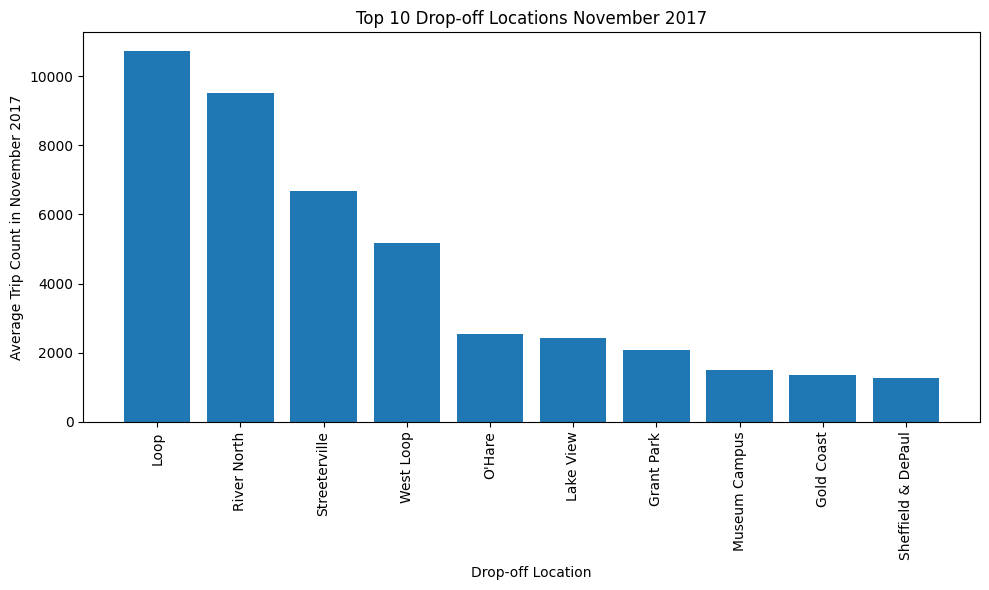

In [41]:
# bar diagram of top 10 locations
top_locations = locations[:10]

# Specify the data and labels
x = top_locations['dropoff_location_name']
y = top_locations['average_trips']

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(x, y)

# Set the title and labels
plt.title('Top 10 Drop-off Locations November 2017')
plt.xlabel('Drop-off Location')
plt.ylabel('Average Trip Count in November 2017')

# Show the plot
plt.xticks(rotation=90)  # Rotate the X-axis labels for better visibility
plt.tight_layout()
plt.show()

The bar chart above shows that the **Loop** was the most popular drop-off location in November 2017. Loop is a central business district in Chicago, so consistently high traffic to this area is expected. Another noteworthy location is O'Hare, home to a major international airport. **Typically, airports in major cities see high traffic. However, this trend does not apply to O'Hare in this case.** It is assumed that the city offers ample transportation alternatives that are more popular than air travel, resulting in significantly lower traffic to O'Hare compared to the top four other locations.

[Back to Analysis](#Analysis)

### Popular Companies

This section analyzes the `companies` table, which contains information on taxi service providers and the number of trips recorded on November 15-16, 2017. A bar chart will display the popularity rankings of the top 10 companies based on the highest trip counts.

In [42]:
# sort table 'companies' based on 'trips_amount'
companies = companies.sort_values(by='trips_amount', ascending=False) #in descending order
companies.head(10)

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


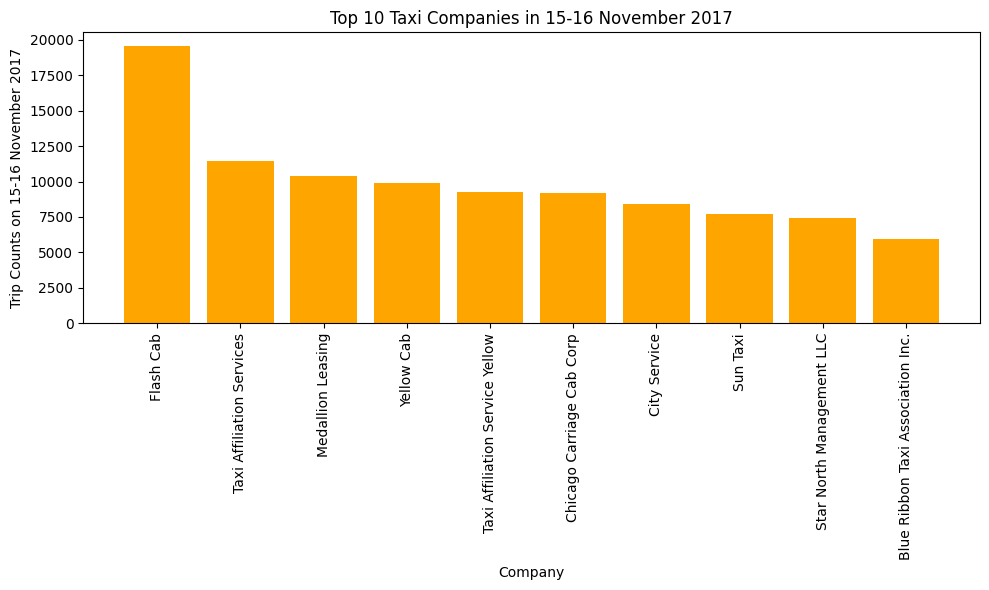

In [43]:
# bar diagram of top 10 companies
top_companies = companies[:10]

x = top_companies['company_name']
y = top_companies['trips_amount']

plt.figure(figsize=(10, 6))
plt.bar(x, y, color='orange')

plt.title('Top 10 Taxi Companies in 15-16 November 2017')
plt.xlabel('Company')
plt.ylabel('Trip Counts on 15-16 November 2017')

plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

he bar chart above illustrates the ranking of taxi companies according to the highest number of trips recorded on November 15-16, 2017. 

A notable finding is the significant gap between the first-ranked company (Flash Cab) and the second-ranked company (Taxi Affiliation Services). However, a similar pattern is not observed between the second and third-ranked companies, and so on down to the last ranked company. This indicates that **during this period, "Flash Cab" dominated a substantial portion of consumer demand**. 

Further investigation is needed into external factors that may have influenced this demand on November 15-16, 2017 (such as weather conditions), as well as Flash Cab's popularity ranking on other days.

[Back to Analysis](#Analysis)

[Back to Contents](#contents)

## Hypothesis Testing

This section focuses on testing the hypothesis regarding the significant differences between trip durations during rainy weather and those during non-rainy weather. 

**The preliminary assumption is that trip durations during rain are longer compared to those in clear weather**. This difference will first be examined based on the distribution descriptions of each dataset. To confirm whether the difference is significant, normality tests for each dataset's distribution, variance homogeneity tests, and ultimately significance tests will be conducted.

### Test of Normality

There are two tables containing records of trips from Loop to O'Hare International Airport during November 2017. One table (`raining_trips`) contains records of trips made during rainy weather, while the other (`other_trips`) includes records of trips made during clear weather. The following is an analysis of the distribution characteristics of each table.

In [38]:
# description of table `raining_trips`
raining_trips.describe()

,duration_seconds
count,212.000000
mean,2501.212264
std,816.822161
min,480.000000
25%,1669.500000
50%,2670.000000
75%,3122.500000
max,4980.000000


A general description of the data distribution in raining_trips indicates that the average trip duration during rainy weather is approximately **41 minutes (2501.2 seconds)**. The shortest trip recorded is 8 minutes, while the longest is 83 minutes. 

There is a wide range between the minimum and maximum values. The standard deviation is also relatively large, measuring 816 seconds (about 13.6 minutes). In this section, a Shapiro-Wilk normality test will be performed to determine the appropriate statistical methods for the hypothesis testing.

In [44]:
# function for normality test
def normality_test(series):
    p_value_shapiro = shapiro(series).pvalue
    print(f'P-Value: {p_value_shapiro}')
    print(f'Alpha  : {alpha}')
    if p_value_shapiro >= alpha:
        print('Fail to reject H0: The data distribution IS normal')
    else:
        print('H0 is rejected: The data distribution is NOT normal')

In [45]:
# apply function to test the normality of table 'raining_trips'
alpha = 0.05
normality_test(raining_trips['duration_seconds'])

P-Value: 2.8165629828436067e-06
Alpha  : 0.05
H0 is rejected: The data distribution is NOT normal


The normality test indicates that the `raining_trips` dataset **does not follow a normal distribution**. The next step is to conduct a normality test for the `other_trips` dataset.

In [41]:
# description of table other_trips
other_trips.describe()

,duration_seconds
count,850.000000
mean,1979.237647
std,702.370046
min,60.000000
25%,1392.000000
50%,1830.000000
75%,2426.750000
max,7440.000000


A general description of the data distribution in `other_trips` reveals that the average trip duration during clear weather is approximately **32 minutes (1979 seconds)**. In line with the preliminary assumption, this average is lower compared to the average trip duration during rainy weather. 

The shortest trip recorded is 1 minute, which, as anticipated, is lower than the shortest trip duration during rainy conditions. However, the longest trip duration is 124 minutes, exceeding the longest trip duration observed during rain. 

There is a wide range between the minimum and maximum values. The standard deviation is also relatively large, at 702 seconds (approximately 11.7 minutes). Next, a Shapiro-Wilk normality test will be conducted to determine the appropriate statistical methods for hypothesis testing.

In [46]:
# apply function to test the normality of table 'other_trips'
alpha = 0.05
normality_test(other_trips['duration_seconds'])

P-Value: 6.838520013668789e-24
Alpha  : 0.05
H0 is rejected: The data distribution is NOT normal


The normality test indicates that the `other_trips` dataset does not follow a normal distribution. The next step is to conduct a variance homogeneity test for both datasets to determine the statistical methods to be used in hypothesis testing.

### Test of Variance Homogenity

In [47]:
# calculate the variance and standard deviation of trip duration during rainy weather
raining_std = round(raining_trips['duration_seconds'].std(), 1)
raining_var = round(raining_trips['duration_seconds'].var(), 1)
print('Trip duration on rainy weather:')
print(f'Standard deviation: {raining_std}')
print(f'Variance: {raining_var}')
print()

# calculate the variance and standard deviation of trip duration during non-rainy weather
other_std = round(other_trips['duration_seconds'].std(), 1)
other_var = round(other_trips['duration_seconds'].var(), 1)
print('Trip duration on non-rainy weather:')
print(f'Standard deviation: {other_std}')
print(f'Variance: {other_var}')
print()

Trip duration on rainy weather:
Standard deviation: 816.8
Variance: 667198.4

Trip duration on non-rainy weather:
Standard deviation: 702.4
Variance: 493323.7



There is a significant difference in variance between the two datasets. This indicates that the datasets do not meet the requirement for homogeneity of variance. Considering the non-normal distribution of both datasets and the lack of homogeneity in variance, the statistical test chosen for hypothesis testing is the **Mann-Whitney U test**.

### Significance of Difference

The hypotheses to be tested are as follows:

* **H0**: There is NO significant difference between the trip duration during rainy weather and the trip duration during non-rainy weather.    

* **H1**: There IS a significant difference between the trip duration during rainy weather and the trip duration during non-rainy weather.

Hypothesis testing will be conducted using the **Mann-Whitney U test** for two independent datasets with non-normal distribution and heterogeneous variance, with an **alpha value of 0.05**.

In [48]:
# test hypothesis
alpha = 0.05
p_value = mannwhitneyu(raining_trips['duration_seconds'], other_trips['duration_seconds'], nan_policy='omit').pvalue
print(f'Alpha  : {alpha}')
print(f'P-Value: {p_value}')
if p_value >= alpha:
    print('Fail to reject H0: There is NO significant difference between the trip duration during rainy weather and the trip duration during non-rainy weather.')
else:
    print('H0 is rejected: There IS a significant difference between the trip duration during rainy weather and the trip duration during non-rainy weather.')

Alpha  : 0.05
P-Value: 4.038109622803852e-19
H0 is rejected: There IS a significant difference between the trip duration during rainy weather and the trip duration during non-rainy weather.


The Mann-Whitney U hypothesis test with an alpha of 0.05 resulted in the rejection of the null hypothesis and the acceptance of the alternative hypothesis. 

For trips from Loop to O'Hare International Airport, **there is a significant difference between the trip duration during rainy weather and the trip duration during non-rainy weather.**

[Back to Hypothesis Testing](#Hypothesis-Testing)

[Back to Contents](#contents)

## Findings and Conclusions

An analysis was conducted to examine the behavior of ride-hailing users in the city of Chicago. The purpose of the analysis is to identify the most popular drop-off locations, company preferences among users, and ride-hailing usage patterns based on weather conditions.

The data utilized in this analysis was sourced from both a public website and a company database. The weather data, capturing daily records for November 2017, was obtained from the website. From the company database, data was gathered on competitor companies (including trip volumes), drop-off locations (along with average trip counts), and trip duration records for the Loop–O'Hare route during November 2017.

During the Data Preparation phase, several data-cleaning and transformation procedures were applied to the raw data. These included renaming columns, identifying and removing duplicate entries, and adjusting data types as necessary.

Data transformation involved categorizing weather descriptions in the `weather_records` table into two classifications: "raining" and "not raining". Additionally, in the Loop–O'Hare trip table (`airport_trips`), the table was simplified to include only the trip date, time, and duration in seconds. The final transformation step was the integration of the weather and trip tables into a unified table, `trip_records`, with the trip date and time serving as the index.

<span style="font-size: 16px; font-weight: bold;">Findings</span>

During the Data Analysis phase, bar charts were generated to illustrate the top 10 destinations and the top 10 taxi companies by trip volume. The findings are summarized as follows:

- In November 2017, the **Loop** area recorded the highest frequency of drop-offs, followed by **River North, Streeterville, West Loop**, and **O’Hare**. The prominence of Loop is likely influenced by its status as the central business district of Chicago. River North and West Loop serve as popular recreational areas, while Streeterville is a major residential district, collectively explaining the elevated traffic to these destinations.    


- A particularly interesting observation is the ranking and trip volume to O’Hare, the international airport. While airports typically exhibit high trip frequencies—often surpassing other destinations within a city—this pattern was not observed at O’Hare. This suggests **a possible preference among Chicago residents for alternative transportation modes to the airport**, which may contribute to the comparatively lower volume of ride-hailing trips to O’Hare.    


- In terms of ride-hailing company popularity, **Flash Cab** was the dominant provider, logging nearly twice the trip volume of its closest competitor, Taxi Affiliation Services. Data collection occurred over two days with predominantly clear weather, indicating that under typical conditions, Flash Cab is the preferred choice among consumers. **Further investigation is warranted** to deepen the understanding of brand popularity, particularly by **examining data from rainy days** to determine if similar trends in company preference persist under adverse weather conditions.    


- In the Hypothesis Testing phase, a Mann-Whitney U test was conducted at a 0.05 alpha level to evaluate the significance of differences in trip duration from Loop to O’Hare between rainy and clear conditions. The significance test results led to the rejection of the null hypothesis, demonstrating **a statistically significant difference in trip duration under rainy versus clear weather conditions**.    

<span id='contents' style="font-size: 16px; font-weight: bold;">Conclusions</span>

The results of the hypothesis test offer a basis for further exploration, specifically in evaluating customer satisfaction with ride-hailing fares. Trips to the airport are frequently associated with a high sense of urgency, while weather remains an external factor beyond the company’s control. A targeted customer satisfaction analysis could reveal valuable insights into areas where the company can maintain or improve customer satisfaction levels, thus enhancing the overall user experience.

[Back to Contents](#contents)